In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import emcee

In [2]:
df = pd.read_csv('antares_processed.csv')
time = df['time'].values
mag = df['Mag'].values
#good = time < 2019.5
#time = time[good]
#mag = mag[good]
from astropy.timeseries import LombScargle
ls = LombScargle(time, mag)
freq, power = ls.autopower()

In [15]:
def rednoise(frequency, alpha0, tau, gamma, alphaw):
    num = alpha0
    den = 1.0 + (2*np.pi*tau*frequency)**gamma
    return num/den + alphaw

def log_rednoise(frequency, alpha0, tau, gamma, alphaw):
    return np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))

from scipy.optimize import curve_fit

def fit_rednoise(time, mag):
    # Input: time and magnitude arrays
    
    # Step 1: Calculate the Lomb-Scargle Periodogram

    ls = LombScargle(time, mag)
    freq, power =ls.autopower()
    
    # Step 1.5: Calculate the log of the lomb-scargle periodogram
    log_power = np.log10(power) 
    
    # Step 2: Curve fit red noise function
    popt,pcov = curve_fit(log_rednoise, freq, log_power, p0 = (0.05, 0.1, 2, 0.01))
    
    alpha0, tau, gamma, alphaw = popt
    err_arr = np.sqrt(np.diag(pcov)) 
   
    return (alpha0, tau, gamma, alphaw), err_arr

arg,err_arr = fit_rednoise(time, mag)

for a,e,l in zip(arg, err_arr,labels):
    print(l,f'{a:.3f}+/-{e:.3f}')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


$\alpha_0$ 0.192+/-0.089
$\tau$ 6.116+/-3.451
$\gamma$ 1.059+/-0.046
$\alpha_w$ 0.001+/-0.000


In [4]:
def log_likelihood(theta, frequency, logpower):
    alpha0, tau, gamma, alphaw = theta
    model = np.log10(rednoise(frequency, alpha0, tau, gamma, alphaw))
    return -0.5 * np.sum((logpower - model) ** 2)

In [5]:
def log_prior(theta):
    alpha0, tau, gamma, alphaw = theta
    if (alphaw < alpha0) & (tau > 1/365) & (alpha0 < 1) & (alphaw > 0):
        return 1/alpha0
    return -np.inf

In [6]:
def log_probability(theta, frequency, logpower):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, logpower)

In [7]:
import emcee

#arg = fit_rednoise(time, mag)

pos = arg + 1e-4 * np.random.randn(32, 4)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(freq, np.log10(power)))
sampler.run_mcmc(pos, 5000, progress=True);

 12%|█▏        | 582/5000 [00:23<02:34, 28.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 5000/5000 [02:35<00:00, 32.08it/s]


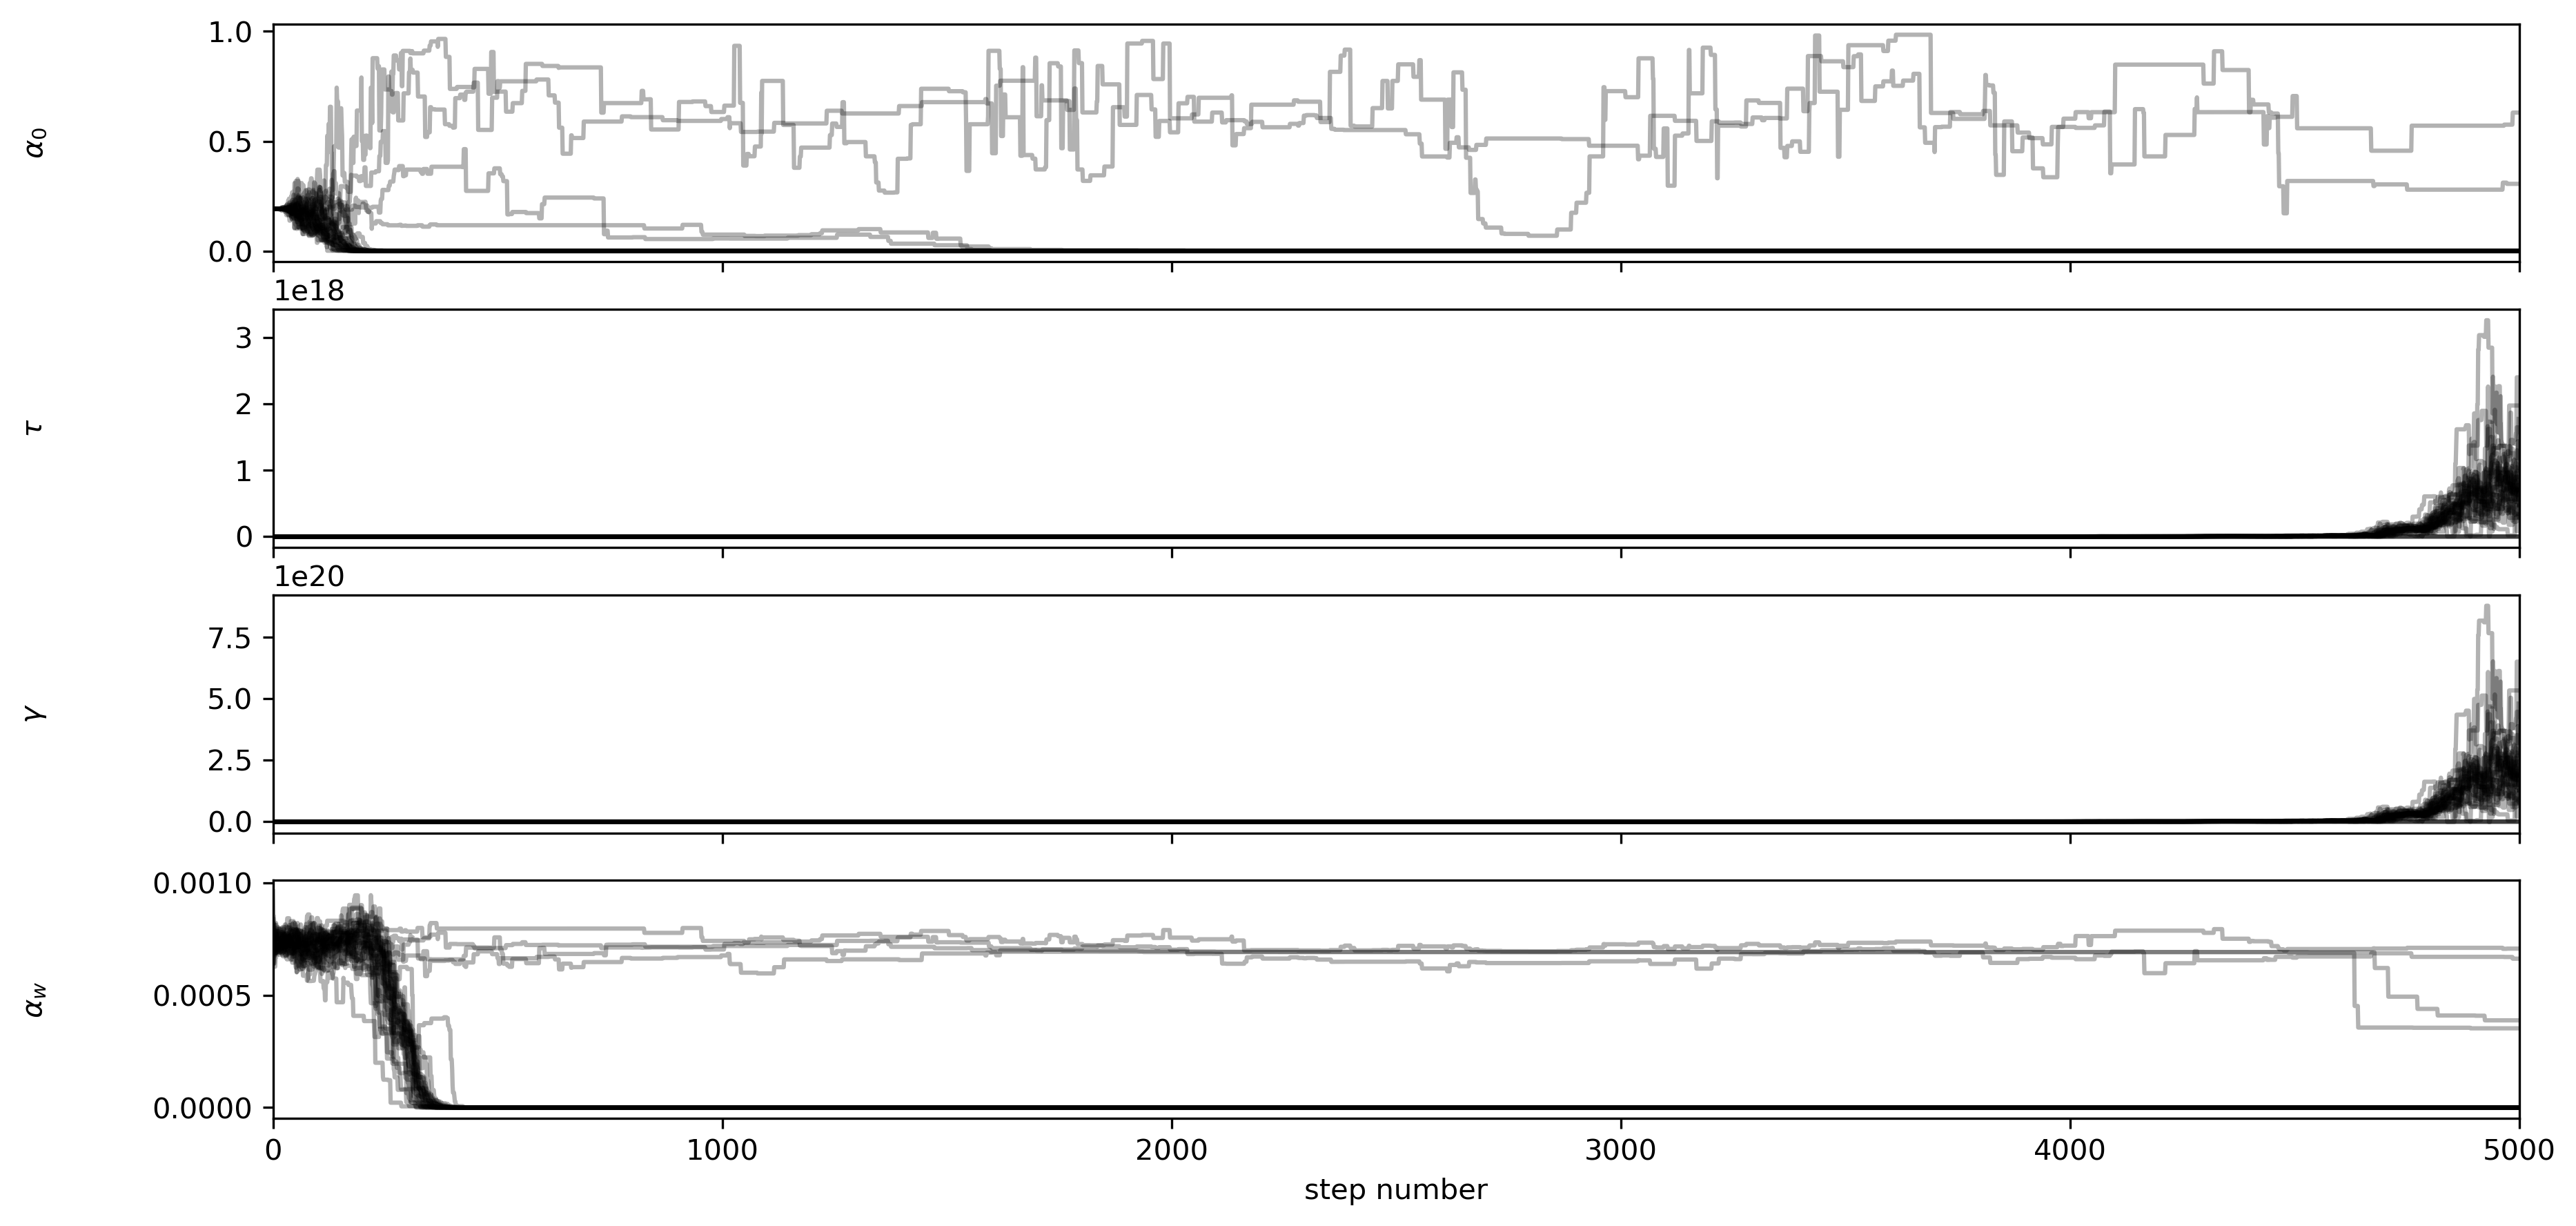

In [11]:
fig, axes = plt.subplots(4, figsize=(14, 7), sharex=True,dpi=300)
samples = sampler.get_chain()
labels = [r"$\alpha_0$", r"$\tau$", r"$\gamma$", r"$\alpha_w$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [14]:
flat_samples.shape

(5000, 4)

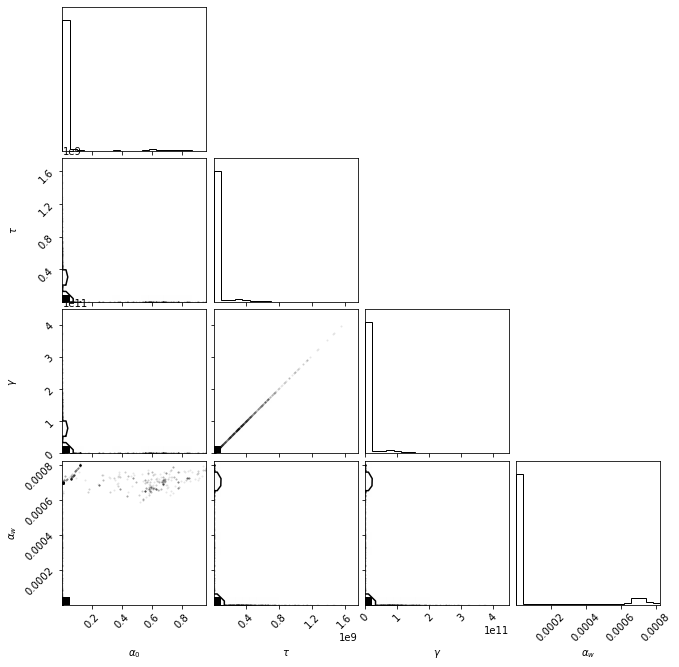

In [13]:
import corner
flat_samples = sampler.get_chain(discard=250, thin=15, flat=True)
flat_samples = flat_samples[:5000,:]
fig = corner.corner(flat_samples, labels=labels,dpi=300)

In [51]:
for i,val in enumerate(labels):
    print(i,val)

0 $\alpha_0$
1 $\tau$
2 $\gamma$
3 $\alpha_w$


In [50]:
for i, val in enumerate(labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(val,mcmc,f"{mcmc[1]:.3f}+{mcmc[2]-mcmc[1]:.3f}-{mcmc[1]-mcmc[0]:.3f}")

$\alpha_0$ [2.80503646e-43 1.47047222e-25 1.43851240e-08] 0.000+0.000-0.000
$\tau$ [1.00514899e+02 3.95959250e+04 1.00030553e+08] 39595.925+99990956.996-39495.410
$\gamma$ [-1.45222961e+09 -1.18917008e+05  9.18460590e-01] -118917.008+118917.927-1452110697.709
$\alpha_w$ [1.36567996e-43 7.26897615e-26 6.22340608e-09] 0.000+0.000-0.000


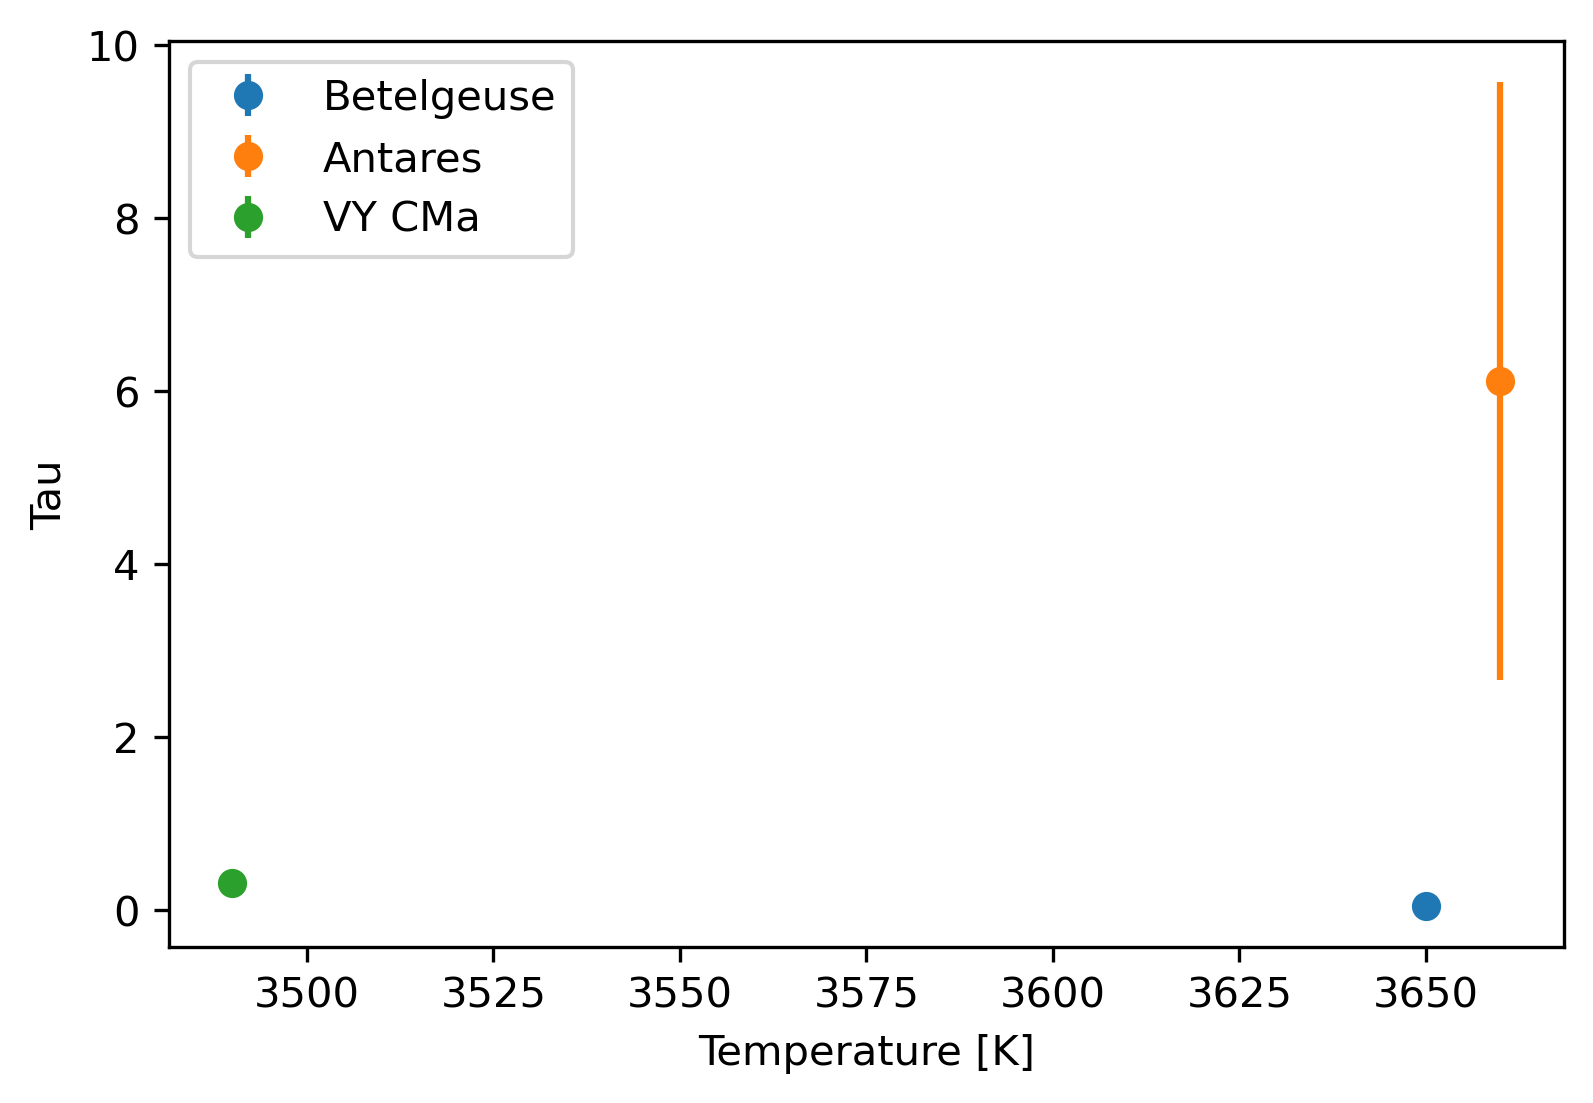

In [43]:
star_data = pd.read_csv('star_data.csv')
star_data
fig = plt.figure(dpi=300)

plt.errorbar([3650],[0.053],yerr=np.array([[0.005,0.006]]).T,fmt='o',label='Betelgeuse')
plt.errorbar([3660],[6.116],yerr=np.array([[3.451,3.451]]).T,fmt='o',label='Antares')
plt.errorbar([3490],[0.314],yerr=np.array([[0.061,0.094]]).T,fmt='o',label='VY CMa')

plt.xlabel('Temperature [K]')
plt.ylabel('Tau')

plt.legend(loc=2)

plt.savefig('Tau_vs_Temperature.pdf')
